<a href="https://colab.research.google.com/github/FelipeFerAl/ImageProcessing/blob/main/Talleres/Taller1_PDI_2024_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Librerias y carga de datos

In [2]:
import numpy as np
import zipfile
import os
import matplotlib.pylab as pylab
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
from google.colab.patches import cv2_imshow
from IPython.display import clear_output
from skimage.io import imread
from skimage.color import rgb2gray, rgba2rgb
from skimage.morphology import binary_erosion, rectangle, square

In [3]:
!git clone https://github.com/FelipeFerAl/ImageProcessing.git

path = '/content/ImageProcessing/images.zip'

extract_path = os.path.dirname('/content/images')

with zipfile.ZipFile(path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

clear_output(False)

#EJERCICIO #1
Tomamos la imagen y la convertimos a formato HSV para facilitar el proceso de separación de colores en base al matiz, la saturación y el valor del color. Inicialmente se utilizó una página externa para detectar algunos valores de los colores, otros fueron ensayo y error

In [4]:
# Carga de la imagen
im=mpimg.imread('/content/images/llaves.jpg')

# Conversión a HSV
hsv_image = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

In [12]:
# Rangos de color en HSV
color_ranges = {
    'black': ((0, 0, 0), (50, 50, 50)),
    'red': ((0, 200, 100), (10, 255, 255)),
    'green': ((40, 50, 50), (80, 255, 255)),
    'blue': ((90, 200, 150), (100, 255, 255)),
}

# Máscaras
masks = {color: cv2.inRange(hsv_image, np.array(lower), np.array(upper))
        for color, (lower, upper) in color_ranges.items()}

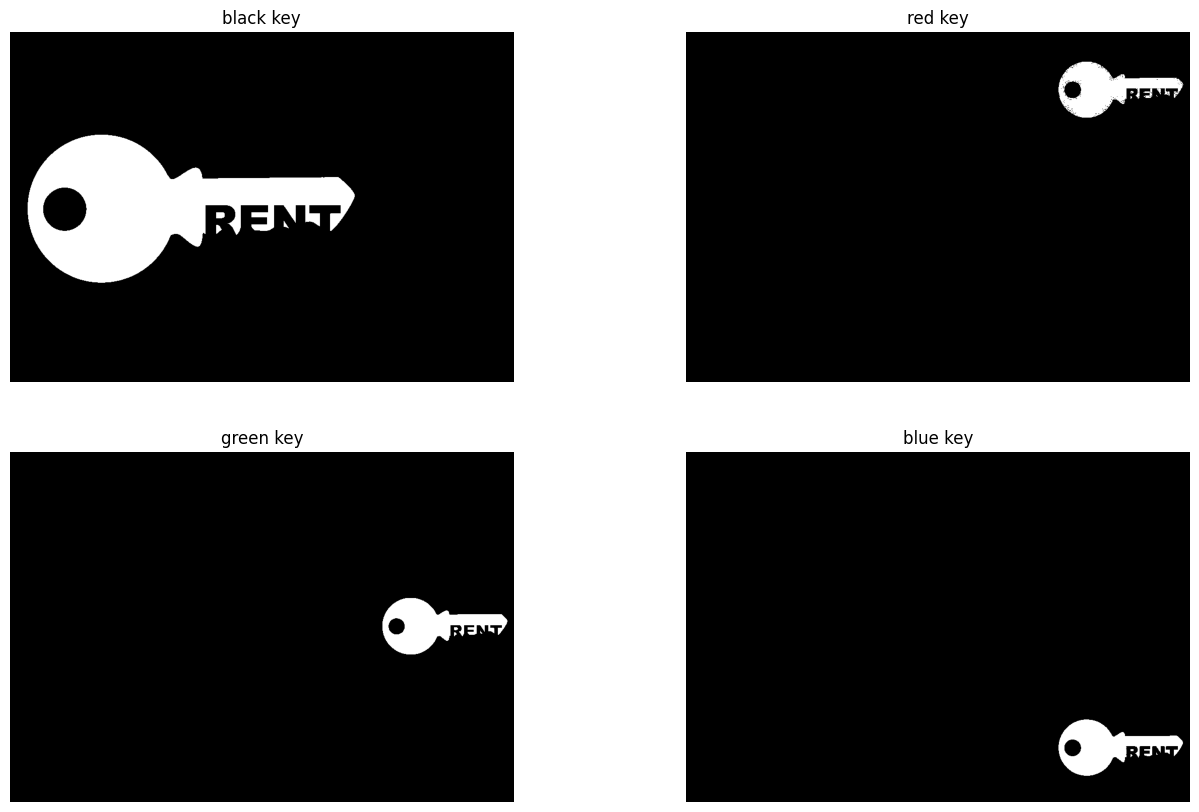

In [13]:
# Figuras
plt.figure(figsize=(16, 10))
for row in range(2):
  for col in range(2):
    idx = row * 2 + col + 1
    plt.subplot(2, 2, idx)
    plt.imshow(masks[list(masks.keys())[idx - 1]], cmap='gray')
    plt.title(list(masks.keys())[idx - 1]+' key')
    plt.axis('off')

#Ejercicio #2
Ambos formatos se convierten en base a fórmulas de normalización y para hallar cada componente necesario en cada pixel. Para el caso de la conversión CMYK se imprime cada una de las capas ya que visualizar los 4 componentes juntos es más complejo

In [66]:
class conv:
  def __init__(self, image):
    self.image = image

  def RGB2HSV(self):
    # Separo los componentes de RGB y los normalizo
    r = self.image[:, :, 0]/255
    g = self.image[:, :, 1]/255
    b = self.image[:, :, 2]/255

    # Máximo y mínimo de cada componente para
    # hallar el delta para calcular el matiz
    c_max = np.maximum.reduce([r, g, b])
    c_min = np.minimum.reduce([r, g, b])
    delta = c_max - c_min

    # Inicializamos vectores para la matiz y la saturación, el valor
    # es definido por el máximo de cada componente
    h = np.zeros_like(c_max)
    s = np.zeros_like(c_max)
    v = c_max

    # Calculamos el matiz
    mask = delta != 0
    r_eq = (c_max == r) & mask
    g_eq = (c_max == g) & mask
    b_eq = (c_max == b) & mask

    # Conversiones de las ecuaciones de transformación
    h[r_eq] = (60 * ((g[r_eq] - b[r_eq]) / delta[r_eq]) % 360)
    h[g_eq] = (60 * ((b[g_eq] - r[g_eq]) / delta[g_eq]) + 120)
    h[b_eq] = (60 * ((r[b_eq] - g[b_eq]) / delta[b_eq]) + 240)

    # Normalizar H en el campo de 360º del cono de HSV
    h = np.where(h < 0, h + 360, h)

    # Cálculo de la saturación
    s[c_max != 0] = delta[c_max != 0] / c_max[c_max != 0]

    # Conversión a rangos CV2 para impresión
    h_opencv = (h / 2).astype(np.uint8)
    s_opencv = (s * 255).astype(np.uint8)
    v_opencv = (v * 255).astype(np.uint8)

    # Combinamos las 3 capas para formar una sola imágen transformada
    hsv_image = np.stack([h_opencv, s_opencv, v_opencv], axis=-1)
    return hsv_image

  def RGB2CMYK(self):
    # Normalizar vectores de color entre 0 y 1
    r = self.image[:, :, 0] / 255.0
    g = self.image[:, :, 1] / 255.0
    b = self.image[:, :, 2] / 255.0

    # Calcular K, componente en negro, es la resta del resto de componentes:
    # Celeste, Magenta y Amarillo
    k = 1 - np.maximum.reduce([r, g, b])

    # Evitamos la división entre 0
    c = np.zeros_like(k)
    m = np.zeros_like(k)
    y = np.zeros_like(k)

    mask = k < 1  #Si el pixel no es negro, debe aplicar a alguna máscara
    c[mask] = (1 - r[mask] - k[mask]) / (1 - k[mask])
    m[mask] = (1 - g[mask] - k[mask]) / (1 - k[mask])
    y[mask] = (1 - b[mask] - k[mask]) / (1 - k[mask])

    # Escalamos para volver a CV2 para impresión
    c_scaled = (c * 255).astype(np.uint8)
    m_scaled = (m * 255).astype(np.uint8)
    y_scaled = (y * 255).astype(np.uint8)
    k_scaled = (k * 255).astype(np.uint8)

    colors = {
        'cyan': c_scaled,
        'magenta': m_scaled,
        'yellow': y_scaled,
        'black': k_scaled
    }
    for row in range(2):
      for col in range(2):
        idx = row * 2 + col + 1
        plt.subplot(2, 2, idx)
        plt.imshow(colors[list(colors.keys())[idx - 1]])
        plt.title(list(colors.keys())[idx - 1]+' intensity')
        plt.axis('off')

array([[[111,  12, 208],
        [111,  12, 208],
        [106,  13, 208],
        ...,
        [ 98,  13, 212],
        [ 98,  13, 211],
        [ 94,  14, 210]],

       [[111,  12, 208],
        [106,  13, 208],
        [106,  13, 208],
        ...,
        [ 98,  13, 215],
        [ 98,  13, 214],
        [ 95,  14, 212]],

       [[110,  15, 209],
        [106,  18, 209],
        [106,  18, 210],
        ...,
        [ 98,  12, 217],
        [ 98,  12, 217],
        [ 94,  14, 215]],

       ...,

       [[ 27, 188, 104],
        [ 27, 213,  87],
        [ 27, 240,  72],
        ...,
        [ 26, 211,  82],
        [ 25, 248,  74],
        [ 24, 220,  97]],

       [[ 28, 226, 108],
        [ 28, 239,  96],
        [ 27, 248,  82],
        ...,
        [ 24, 197, 128],
        [ 24, 219, 129],
        [ 24, 207, 157]],

       [[ 28, 255, 102],
        [ 28, 255,  99],
        [ 27, 221,  98],
        ...,
        [ 24, 179, 162],
        [ 24, 190, 173],
        [ 23, 178, 216]]], dtype=uint8)
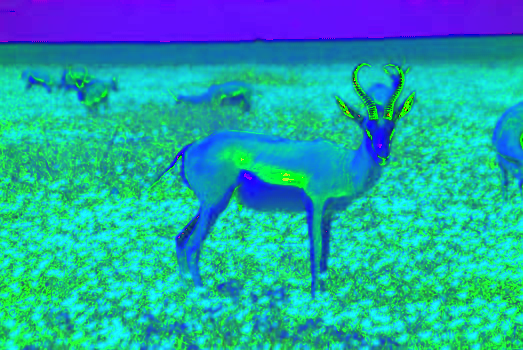

In [64]:
Conversion1 = conv(mpimg.imread('/content/images/antelops.jpeg'))
Conversion1.RGB2HSV()

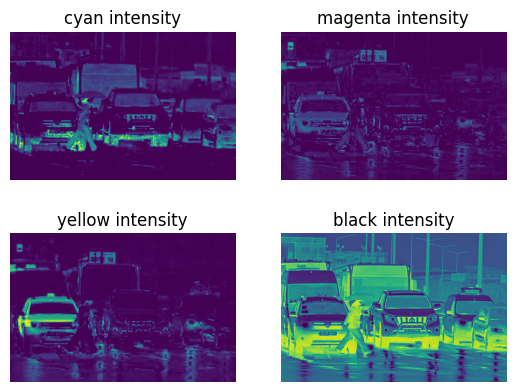

In [67]:
Conversion2 = conv(mpimg.imread('/content/images/cars.jpg'))
Conversion2.RGB2CMYK()